# Trabajo práctico 1 - Simulación

In [1]:
import sys
!{sys.executable} -m pip install scipy

import matplotlib.pyplot as plt
from collections import Counter
from random import random
import math
import scipy.stats as st
import numpy as np

## Ejercicio 1

**1- Utilizando Matlab, Octave o Python implementar un Generador Congruencial Lineal (GCL) de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera de la suma ponderada (0,15-0,25-0,6) de los números de padrón de los integrantes del grupo, ordenados ascendentemente.**
* **Informar los primeros 5 números de la secuencia.**
* **Modificar el GCL para que devuelva números al azar entre 0 y 1, y realizar un histograma sobre 100.000 valores generados.**

In [43]:
def GCL(multiplier, seed, increment, module, generated_length):
    l = [(multiplier * seed + increment) % module]
    for i in range(1, generated_length):
        l.append( (multiplier * l[i-1] + increment) % module)
    return l

def plot_values(histogram_values, title, x_label, y_label, num_bins = 100, relative_frequency = 0):
    fig, ax = plt.subplots()

    n, bins, patches = ax.hist(histogram_values, num_bins, density=1)
    if(relative_frequency):
        gcl_histogram = plt.hist(histogram_values, bins = num_bins, weights=np.zeros_like(histogram_values) + 1. / len(histogram_values))
    else:
        gcl_histogram = plt.hist(histogram_values, bins = num_bins)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()

In [44]:
seed = int(99136 * 0.15 + 92308 * 0.25 + 97092 * 0.6)
five_numbers = GCL(1013904223, seed, 1664525, 232, 5)
five_numbers

[107, 178, 51, 154, 107]

In [45]:
histogram_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))

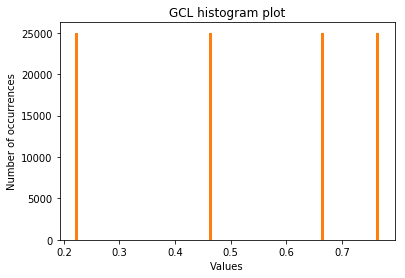

In [55]:
plot_values(histogram_values, 'GCL histogram plot', 'Values', 'Number of occurrences')

In [56]:
counting_elements = Counter(histogram_values)
counting_elements

Counter({0.21982758620689655: 25000,
         0.46120689655172414: 25000,
         0.6637931034482759: 25000,
         0.7672413793103449: 25000})

Como se puede observar, hay únicamente 4 valores diferentes que se repiten 25000 veces cada uno. El rango del GCL con esos valores es 4, mucho menor al módulo provisto.

## Ejercicio 2

**Utilizando el generador de números aleatorios con distribución uniforme [0,1] implementado en el ejercicio 1 y utilizando el método de la transformada inversa genere números pseudoaleatorios con distribución exponencial negativa de media 20.**
* **Realizar un histograma de 100.000 valores obtenidos.**
* **Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.**

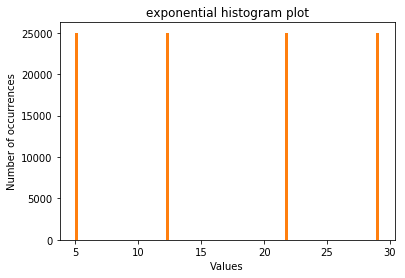

In [57]:
def inversa_exponencial(random_value, lambda_value = 1):
    return (-1/lambda_value) * math.log(1 - random_value)

lambda_value = 1/20

# This are the values generated with random input
#exponencial_values = [inversa_exponencial(random(), lambda_value) for _ in range(100000)]
histogram_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))
exponencial_values = list(map(lambda x: inversa_exponencial(x, lambda_value), histogram_values))

plot_values(exponencial_values, 'exponential histogram plot', 'Values', 'Number of occurrences')

In [58]:
exponential_mean = np.mean(exponencial_values)
exponential_standard_deviation = np.std(exponencial_values)

In [59]:
print("Esperanza: ", exponential_mean)
print("Varianza: ", exponential_standard_deviation ** 2)

Esperanza:  17.0722292242
Varianza:  84.266793701


Tal como era de esperar, los cuatro valores generados por la función de GCL se transforman en otros nuevos 4 valores. Tanto la forma del gráfico como los valores de la esperanza y la varianza (deberían ser 20 y 400 respectivamente) distan de lo esperado.

## Ejercicio 3

**Utilizando el método de Box-Muller genere de números aleatorios con distribución normal standard.**
* **Realizar un histograma de 100.000 valores obtenidos.**
* **Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.**

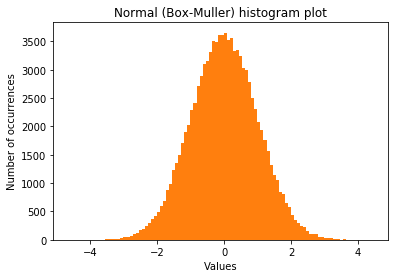

In [60]:
def box_muller(u1, u2):
    z1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    z2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return z1,z2


normal_values = []
for _ in range(50000):
    normal_values_tuple = box_muller(random(), random())
    normal_values.append(normal_values_tuple[0])
    normal_values.append(normal_values_tuple[1])
    

plot_values(normal_values, 'Normal (Box-Muller) histogram plot', 'Values', 'Number of occurrences')

In [61]:
normal_mean = np.mean(normal_values)
normal_standard_deviation = np.std(normal_values)
print("Esperanza: ", normal_mean)
print("Varianza: ", normal_standard_deviation ** 2)

Esperanza:  0.0018856440436
Varianza:  0.996878867545


Los valores obtenidos son muy similares a los esperados

## Ejercicio 4

**Genere 100.000 número aleatorios condistribución Normal de media 40 y desvío estándar 6 utilizando el algoritmo de Aceptación y Rechazo.**
* Realizar un histograma de frecuencias relativas con todos los valores obtenidos.
* Comparar, en el mismo gráfico, el histograma realizado en el punto anterior con la distribución normal brindada por Matlab, Octave o Python.
* Calcular la media y la varianza de la distribución obtenida y compararlos con los valores teóricos.

Del punto anterior, podemos decir que conocemos una distribución normal estandard que la llamaremos Y(t), mientras que queremos generar X(t) que es la distribución normal de media 40 y desvío 6.

1- Necesitamos encontrar una cota superior c, tal que, c >= X(t)/Y(t)
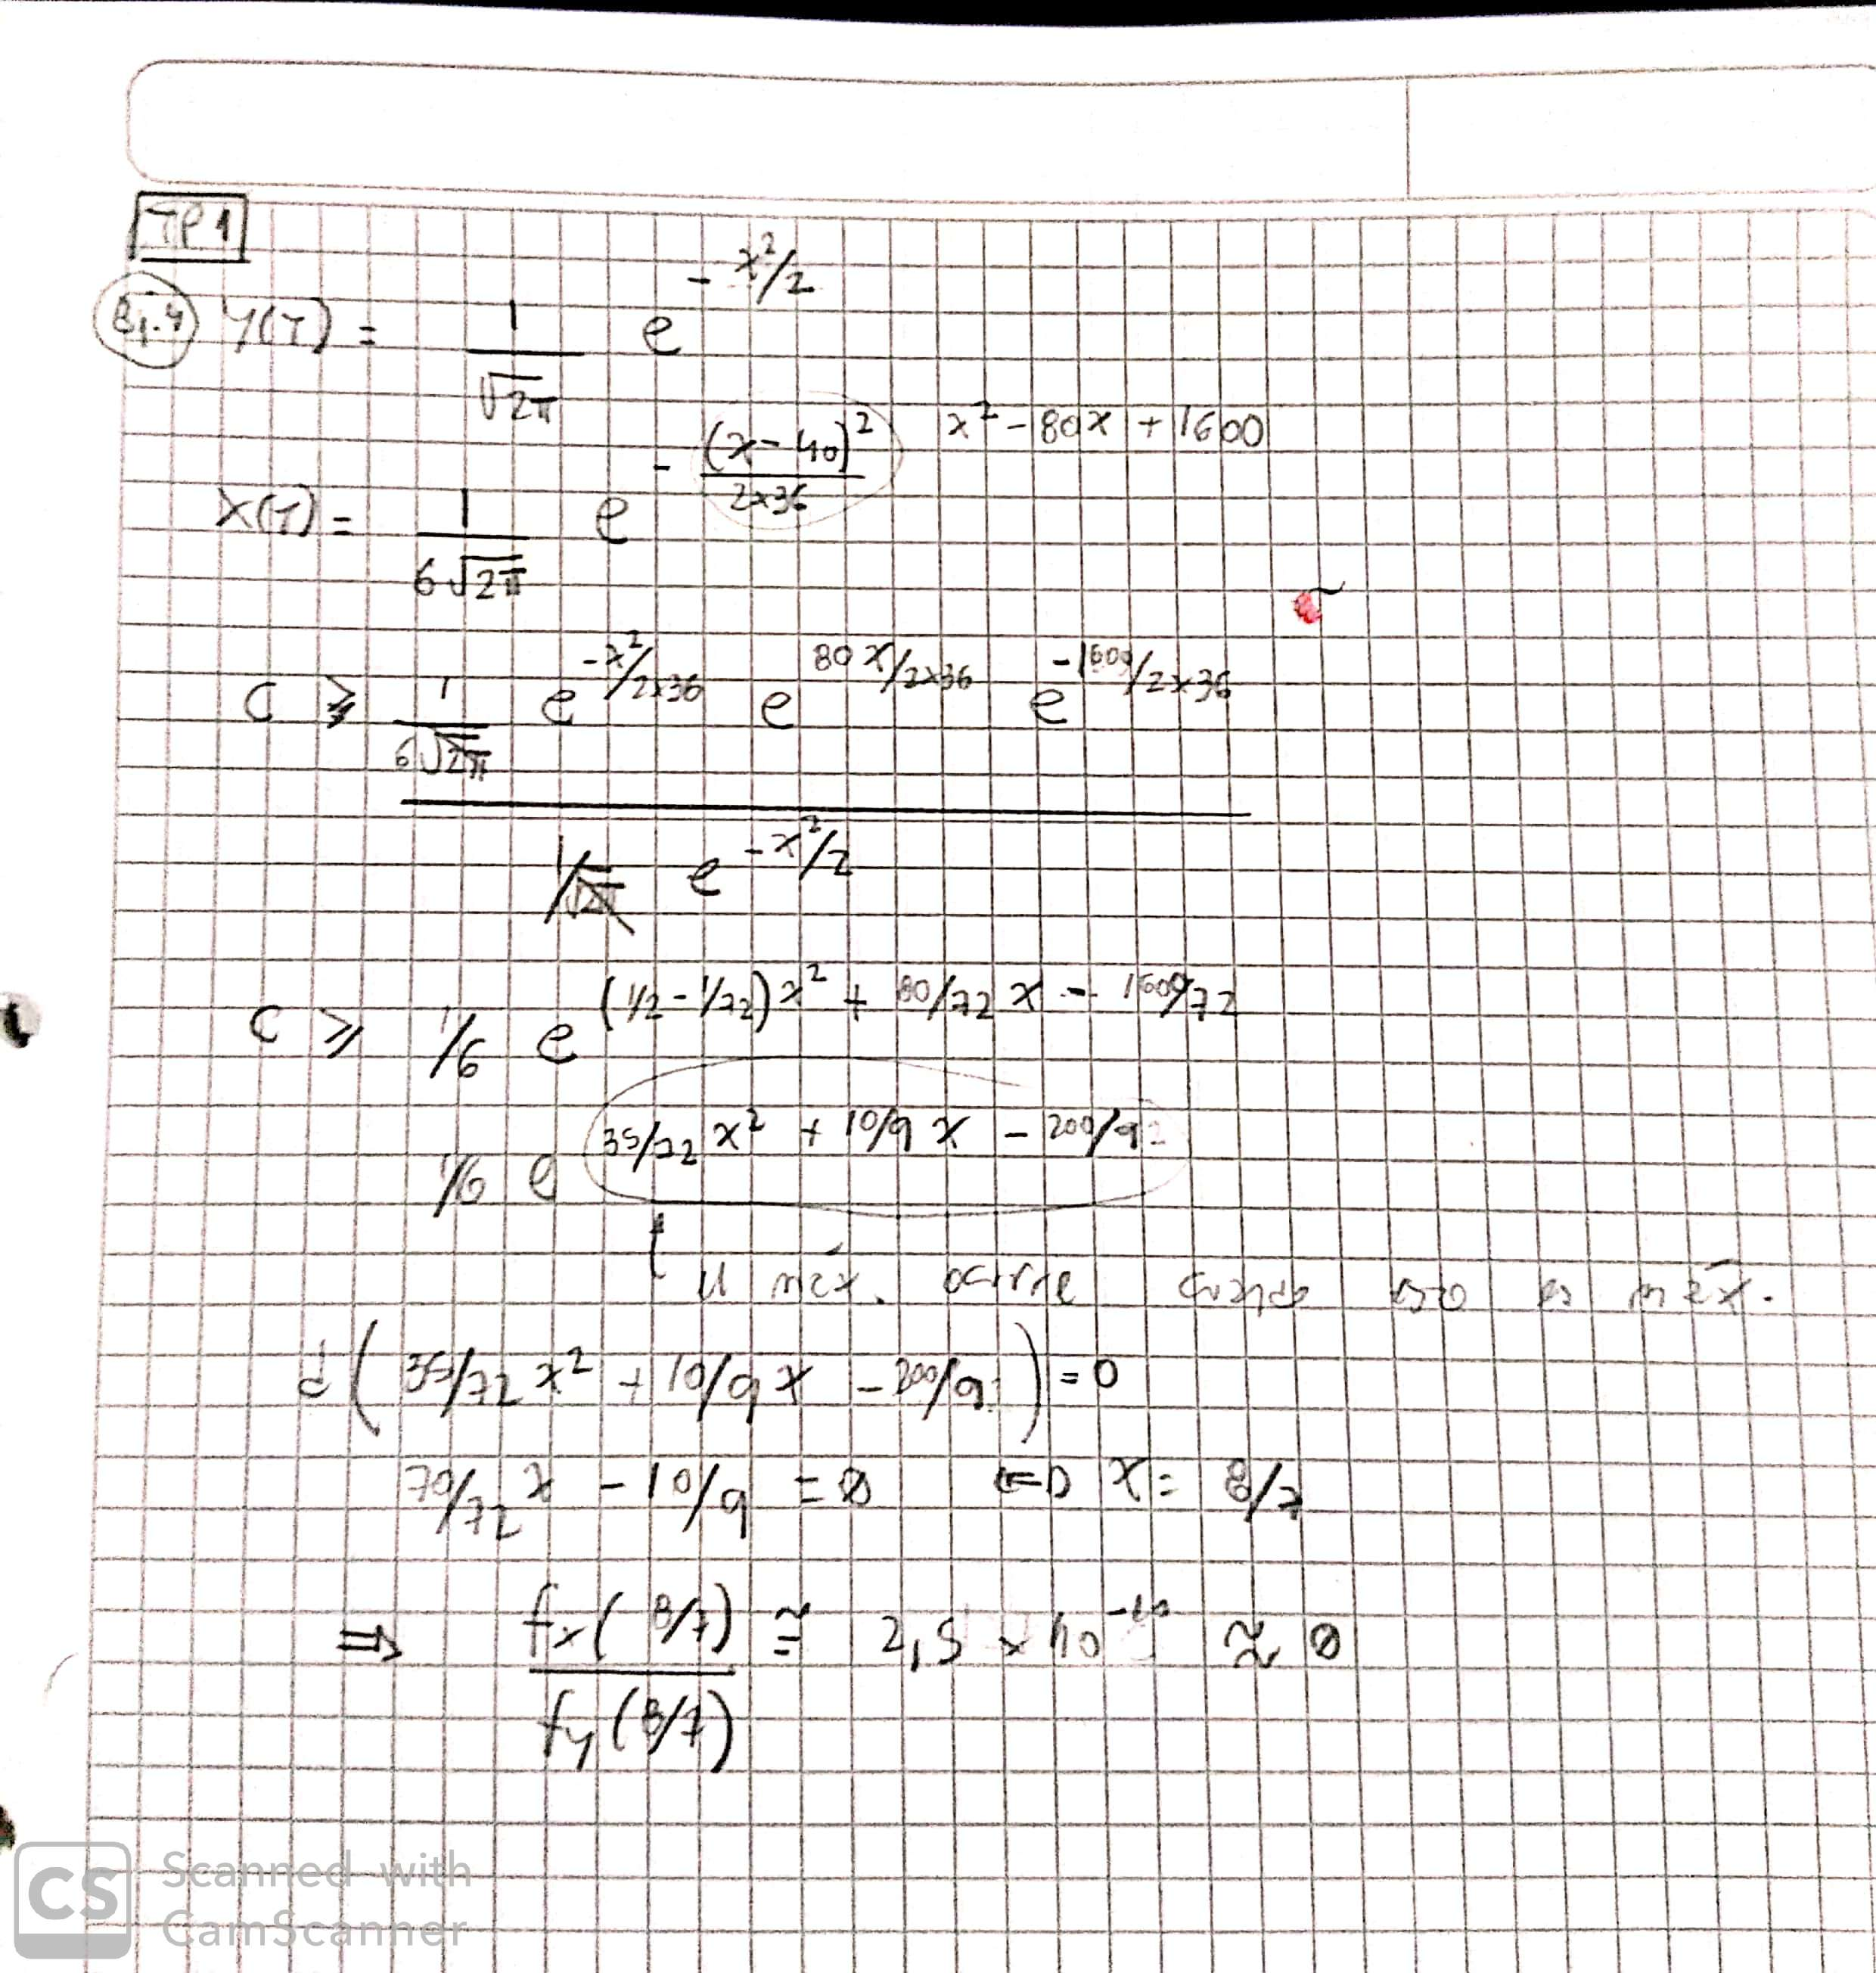

2- Sabiendo que c=0.121, entonces generamos un número al azar de Y(t) con box_muller(u1,u2) que lo llamaremos a

3- Generamos un número al azar entre 0 y 1 que lo llamaremos u

4- Si u <= X(a)/c*Y(a) entonces a es el valor generado, sino volvemos a 2

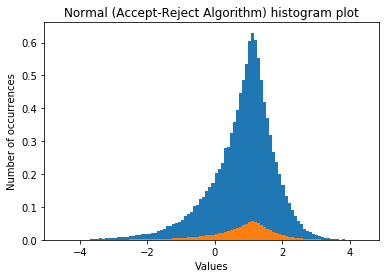

In [67]:
def accept_reject_method_normal(iteraciones):
    l = []
    c = 0.00000000025
    while (len(l) < iteraciones):
        (z,a) = box_muller(random(), random())
        u = random()
        x = (1/6) * math.exp( (35/72) * (a ** 2) + (10/9) * a - 200/9 )
        if (u <= x / c):
            l.append(a)
    return l

accept_reject_normal_values = accept_reject_method_normal(100000)
plot_values(accept_reject_normal_values, 'Normal (Accept-Reject Algorithm) histogram plot', 'Values', 'Number of occurrences', relative_frequency = 1)

Este gráfico debería mostrar algo parecido a una gaussiana de media 40, sin embargo, no está ni cerca. Cuál es el error?

In [66]:
accept_reject_normal_mean = np.mean(accept_reject_normal_values)
accept_reject_normal_deviation = np.std(accept_reject_normal_values)
print("Esperanza: ", accept_reject_normal_mean)
print("Varianza: ", accept_reject_normal_deviation ** 2)

Esperanza:  0.822155986974
Varianza:  0.929907155244


## Ejercicio 5
Utilizando el método de la transformada inversa y utilizando el generador de números aleatorios implementado en el ejercicio 1 genere números aleatorios siguiendo la siguiente función de distribución de probabilidad empírica.
Probabilidad      Valor generado
     .4                 1
     .3                 2
     .12                3
     .1                 4
     .08                5
     
Muestre los resultados obtenidos en un histograma.

In [ ]:
def transform_values_to_discrete_distribution(u):
    if (u <= 0.4):
        return 1
    elif (u <= 0.7):
        return 2
    elif (u <= 0.82):
        return 3
    elif (u <= 0.92):
        return 4
    else:
        return 5

# This are the values generated with random input
#discrete_values = [transform_values_to_discrete_distribution(random()) for _ in range(100000)]

ej1_values = list(map(lambda x: x/232, GCL(1013904223, seed, 1664525, 232, 100000)))
discrete_values = list(map(lambda x: transform_values_to_discrete_distribution(x), ej1_values))

plot_values(discrete_values, 'Discrete histogram plot', 'Values', 'Number of occurrences', num_bins = 5)

## Ejercicio 6
Utilizando 2 generadores de números al azar, provistos por el lenguaje elegido para resolver el tp, con distribuciones uniformes en [-1,1] genere números aleatorios en un círculo de radio 1 centrado en el origen.
Muestre el resultado en un gráfico de 2 dimensiones.

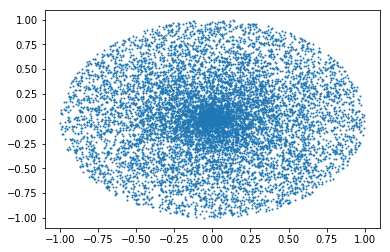

In [91]:
def circle_point():
    angle = random() * math.pi * 2
    distance_to_center = random()
    x = math.cos(angle) * distance_to_center
    y = math.sin(angle) * distance_to_center
    return (x, y)
    
x_points = []
y_points = []
for _ in range(10000):
    x, y = circle_point()
    x_points.append(x)
    y_points.append(y)

    
plt.scatter(x_points, y_points, s = 1)
plt.show()